In [1]:
import pandas as pd
import numpy as np
import requests
import json
import os
import time
import fred_msa
import datetime as dt
from datetime import date
import regex as re
import seaborn as sns
import matplotlib.pyplot as plt

##########
# STEP 1 - PULL DATA FROM CSVS
##########

msa_filepath = '..\\msa-data'
msa_files = os.listdir(msa_filepath) # all msa files

county_filepath = '..\\county-data'
county_files = os.listdir(county_filepath) # all msa files


# remove python checkpoints folders
try:
    msa_files.remove('.ipynb_checkpoints')
except ValueError:
    pass

try:
    county_files.remove('.ipynb_checkpoints')
except ValueError:
    pass

 # dict to rename columns from FRED series names
file_to_col = {
    'All-Transactions House Price Index.csv' : 'hpi',
    'Average Weekly Wages for Employees in Total Covered Establishments.csv' : 'weekly_wages',
    'Home Price Index (Middle Tier).csv' : 'hpi-large',
    'Housing Inventory - Median Listing Price.csv' : 'median_listing_price',
    'Regional Price Parities.csv' : 'rpp',
    'Resident Population.csv' : 'population',
    'Total Gross Domestic Product.csv' : 'gdp',
    'Unemployment Rate.csv': 'unemployment_rate',
    'Combined Violent and Property Crime Offenses.csv' : 'crimes',
    'Equifax Subprime Credit Population.csv' : 'subprime',
    'Estimated Percent of People of All Ages in Poverty.csv' : 'poverty',
    'New Patent Assignments.csv' : 'patents',
    'Number of Private Establishments for All Industries.csv' : 'private_establishments',
    'Premature Death Rate.csv' : 'premature_death_rate',
    'SNAP Benefits Recipients.csv' : 'snap'
}


# bring in msa data as a dict and change dtypes

msa_data_dict = fred_msa.get_data_dict(msa_files, msa_filepath, file_to_col, '2008-01-01') # pull in data and metadata

msa_id_vars = ['date', 'year', 'month', 'city', 'msa_state', 'quarter'] # id variables - not predictors

for k, v in msa_data_dict.items():
    v['data'] = fred_msa.convert_dtypes(v['data'], msa_id_vars)

#data = fred_msa.convert_data_to_df(data_dict, ['date', 'year', 'month', 'city', 'state'], 'housing_median_listing_price') # convert to df

county_data_dict = fred_msa.get_data_dict(county_files, county_filepath, file_to_col, '2008-01-01') # pull in data and metadata

county_id_vars = ['date', 'year', 'quarter', 'month', 'city', 'county', 'state', 'msa_state'] # id variables - not predictors

for k, v in county_data_dict.items():
    v['data'][k] = v['data'][k].replace('.', np.nan) # some nulls designated with "."
    v['data'] = fred_msa.convert_dtypes(v['data'], county_id_vars) # convert dtypes
    
    # interpolate missing values
    v['data'][k] = v['data'].groupby(['city', 'state', 'county'])[k].apply(lambda group: group.interpolate(method='linear', limit=20, limit_direction='both'))

#data = fred_msa.convert_data_to_df(data_dict, ['date', 'year', 'month', 'city', 'state'], 'housing_median_listing_price') # convert to df

##########
# STEP 2 - COMBINE HPI FOR SMALL AND LARGE CITIES
##########

# convert monthly HPI for large cities to quarterly
msa_data_dict['hpi-large']['data'] = msa_data_dict['hpi-large']['data'].query("month in [1,4,7,10]")

# combine hpi for small and large cities
msa_data_dict = fred_msa.combine_series(msa_data_dict, 'hpi', 'hpi-large')

##########
# STEP 3 - LINK HPI TO MEDIAN HOUSING PRICE
##########

# get median listing price at end of 2019
med_prices_2020 = msa_data_dict['median_listing_price']['data'].query(
    "date=='2019-10-01'").drop(columns=['date', 'year', 'month', 'quarter']).reset_index(drop=True)

# remove listing price from dictionary (no longer needed)
del msa_data_dict['median_listing_price']

# incorporate LA
la_med_listing_id = 'MEDLISPRI6037'

api_key = 'a37b50cd27afbc3ce23a81ddc5541dec'

la_2020_med_price = float(fred_msa.get_series(la_med_listing_id, api_key).query("date=='2019-10-01'").value)

med_prices_2020 = med_prices_2020.append({'city' : 'Los Angeles',
                       'msa_state' : 'CA',
                       'median_listing_price' : la_2020_med_price}, ignore_index=True)

# create HPI multiplier to compare between cities, based on median in Q1 2020
med_prices_2020['multiplier'] = med_prices_2020.median_listing_price/np.median(med_prices_2020.median_listing_price)

# use merge to add multiplier to HPI dataset
msa_data_dict['hpi']['data'] = pd.merge(
    msa_data_dict['hpi']['data'], med_prices_2020.drop(
    columns=['median_listing_price']), how='left', on=['city', 'msa_state'], validate='many_to_one')

# calculate adjusted HPI
msa_data_dict['hpi']['data']['hpi'] = msa_data_dict['hpi']['data'].hpi*msa_data_dict['hpi']['data'].multiplier

In [2]:
##########
# STEP 4 - AGGREGATING COUNTY DATA
##########

# extract and remove population from other data series

county_pop = county_data_dict['population']['data']
del county_data_dict['population']

# sum county populations across MSAs
msa_pops = pd.DataFrame(county_pop.groupby(['year', 'msa_state', 
                                            'city'])['population'].sum()).reset_index().rename(columns={'population' : 'msa_pop'})

county_pop = pd.merge(county_pop, msa_pops, how = 'left', on=['year', 'msa_state', 'city'], validate='many_to_one')

# calculate weights for each county
county_pop['pop_fraction'] = county_pop.population/county_pop.msa_pop

# add population column to each series
for k, v in county_data_dict.items():
    v['data'] = pd.merge(v['data'], county_pop.drop(columns=['date', 'msa_state', 'city']),
                        how='left', on=['county', 'state', 'year'])


In [11]:
for k, v in county_data_dict.items():
    pre_20 = v['data'].query("year < 2020")
    print((k, v['data'].shape[0], sum(pre_20[k].isna())))

('crimes', 1240, 0)
('subprime', 6105, 0)
('poverty', 1443, 0)
('patents', 13488, 581)
('private_establishments', 5994, 0)
('premature_death_rate', 1332, 0)
('snap', 1332, 0)


In [9]:
msa_data_dict['hpi']['data']

,date,hpi,msa_state,city,year,quarter,multiplier
0,2008-01-01,361.226779,SC,Charleston,2008,1,1.342152
1,2008-04-01,355.616583,SC,Charleston,2008,2,1.342152
2,2008-07-01,344.436457,SC,Charleston,2008,3,1.342152
3,2008-10-01,341.161607,SC,Charleston,2008,4,1.342152
4,2009-01-01,344.275399,SC,Charleston,2009,1,1.342152
...,...,...,...,...,...,...,...
955,2018-10-01,383.538057,NY,New York,2018,4,1.800381
956,2019-01-01,388.377299,NY,New York,2019,1,1.800381
957,2019-04-01,387.369467,NY,New York,2019,2,1.800381
958,2019-07-01,390.188390,NY,New York,2019,3,1.800381


In [3]:
weighted_avg_series = ['subprime', 'poverty', 'premature_death_rate']

# aggreagte - either by sum or weighted average
for k, v in county_data_dict.items():
    
    if k in weighted_avg_series:
        v['data'][k] = v['data'][k]*v['data']['pop_fraction']
    
    if v['frequency'] == 'Annual':
        grouped = v['data'].groupby(['date', 'city', 'msa_state', 'year'])

    elif v['frequency'] == 'Quarterly':
        grouped = v['data'].groupby(['date', 'city', 'msa_state', 'year', 'quarter'])

    else:
        grouped = v['data'].groupby(['date', 'city', 'msa_state', 'year', 'quarter', 'month'])
        
        
    aggregated = pd.DataFrame(grouped[k].sum()).reset_index()
        
    v['data'] = aggregated

##########
# STEP 5 - CREATE UNIFIED DF
##########

combined_data_dict = msa_data_dict | county_data_dict

hpi_data = fred_msa.convert_data_to_df(combined_data_dict, msa_id_vars, 'hpi')

hpi_data.to_csv('..\\working-data\\hpi-data.csv', index=False)

In [10]:
#hpi_data.groupby(['city', 'msa_state'])['population'].apply(lambda group: group.interpolate())
annual_cols = [k for k, v in combined_data_dict.items() if v['frequency'] == 'Annual']
for col in annual_cols:
    hpi_data[col] = hpi_data.groupby(['city', 'msa_state'])[col].apply(lambda group: group.interpolate())

In [4]:
hpi_data.head()

,date,quarter,msa_state,year,city,hpi,weekly_wages,rpp,population,gdp,unemployment_rate,crimes,subprime,poverty,patents,private_establishments,premature_death_rate,snap
0,2008-01-01,1,SC,2008,Charleston,361.226779,733.576515,97.6410,647.19400,27277.61300,4.8,10083.0,42.546860,13.983937,7.000000,16277.0,395.327521,69915.00
1,2008-04-01,2,SC,2008,Charleston,355.616583,728.179263,97.6635,650.19325,27192.92025,5.1,10058.5,42.203499,14.355264,6.000000,16760.0,393.136641,73917.75
2,2008-07-01,3,SC,2008,Charleston,344.436457,732.479714,97.6860,653.19250,27108.22750,6.0,10034.0,42.138782,14.726591,4.000000,16960.0,390.945760,77920.50
3,2008-10-01,4,SC,2008,Charleston,341.161607,731.680084,97.7085,656.19175,27023.53475,7.0,10009.5,42.177472,15.097918,4.500000,16680.0,388.754880,81923.25
4,2009-01-01,1,SC,2009,Charleston,344.275399,732.465819,97.7310,659.19100,26938.84200,8.2,9985.0,41.945581,15.469245,3.666667,15846.0,386.564000,85926.00


In [4]:
[v['data'].columns for k, v in combined_data_dict.items()]

[Index(['date', 'hpi', 'msa_state', 'city', 'year', 'quarter', 'multiplier'], dtype='object'),
 Index(['date', 'weekly_wages', 'msa_state', 'city', 'year', 'quarter'], dtype='object'),
 Index(['date', 'rpp', 'msa_state', 'city', 'year'], dtype='object'),
 Index(['date', 'population', 'msa_state', 'city', 'year'], dtype='object'),
 Index(['date', 'gdp', 'msa_state', 'city', 'year'], dtype='object'),
 Index(['date', 'unemployment_rate', 'msa_state', 'city', 'year', 'month',
        'quarter'],
       dtype='object'),
 Index(['date', 'city', 'msa_state', 'year', 'crimes'], dtype='object'),
 Index(['date', 'city', 'msa_state', 'year', 'quarter', 'subprime'], dtype='object'),
 Index(['date', 'city', 'msa_state', 'year', 'poverty'], dtype='object'),
 Index(['date', 'city', 'msa_state', 'year', 'quarter', 'month', 'patents'], dtype='object'),
 Index(['date', 'city', 'msa_state', 'year', 'quarter',
        'private_establishments'],
       dtype='object'),
 Index(['date', 'city', 'msa_state', 

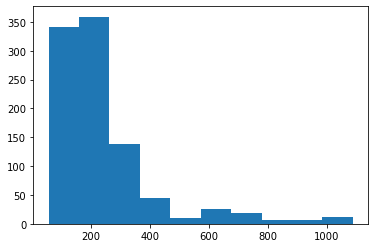

In [12]:
plt.hist(hpi_data.hpi)
plt.show()

In [2]:
['a', 'b', 'c'] + ['d']

['a', 'b', 'c', 'd']

In [6]:
[k for k, v in combined_data_dict.items() if v['frequency'] == 'Annual']

['rpp',
 'population',
 'gdp',
 'crimes',
 'poverty',
 'premature_death_rate',
 'snap']

Remaining activities:

- deal with time (MONTHLY AGGREGATION)
- combine msa and county data into one df
- create VAR functionality

In [7]:
hpi_data.head(20)

,date,quarter,msa_state,year,city,hpi,weekly_wages,rpp,population,gdp,unemployment_rate,crimes,subprime,poverty,patents,private_establishments,premature_death_rate,snap
0,2008-01-01,1,SC,2008,Charleston,361.226779,733.576515,97.64100,647.19400,27277.61300,4.8,10083.00,42.546860,13.983937,7.000000,16277.0,395.327521,69915.00
1,2008-04-01,2,SC,2008,Charleston,355.616583,728.179263,97.66350,650.19325,27192.92025,5.1,10058.50,42.203499,14.355264,6.000000,16760.0,393.136641,73917.75
2,2008-07-01,3,SC,2008,Charleston,344.436457,732.479714,97.68600,653.19250,27108.22750,6.0,10034.00,42.138782,14.726591,4.000000,16960.0,390.945760,77920.50
3,2008-10-01,4,SC,2008,Charleston,341.161607,731.680084,97.70850,656.19175,27023.53475,7.0,10009.50,42.177472,15.097918,4.500000,16680.0,388.754880,81923.25
4,2009-01-01,1,SC,2009,Charleston,344.275399,732.465819,97.73100,659.19100,26938.84200,8.2,9985.00,41.945581,15.469245,3.666667,15846.0,386.564000,85926.00
5,2009-04-01,2,SC,2009,Charleston,334.692434,735.877671,97.98025,661.26700,27298.34625,9.2,9942.50,41.808662,15.669006,3.166667,15908.0,389.148380,88296.00
6,2009-07-01,3,SC,2009,Charleston,321.673560,745.535901,98.22950,663.34300,27657.85050,9.7,9900.00,41.933987,15.868767,3.000000,15967.0,391.732760,90666.00
7,2009-10-01,4,SC,2009,Charleston,313.352218,767.574508,98.47875,665.41900,28017.35475,10.1,9857.50,42.309420,16.068528,3.545455,15487.0,394.317140,93036.00
8,2010-01-01,1,SC,2010,Charleston,309.191547,725.304587,98.72800,667.49500,28376.85900,9.8,9815.00,41.895220,16.268288,4.090909,15558.0,396.901520,95406.00
9,2010-04-01,2,SC,2010,Charleston,300.601774,771.758019,98.95500,670.98350,28832.13050,9.4,9741.75,41.684003,16.414634,4.636364,15397.0,391.943769,96504.50


In [28]:
[(k, v['data'].columns) for k, v in county_data_dict.items()]

[('crimes',
  Index(['date', 'city', 'msa_state', 'year', 'crimes'], dtype='object')),
 ('subprime',
  Index(['date', 'city', 'msa_state', 'year', 'quarter', 'subprime'], dtype='object')),
 ('poverty',
  Index(['date', 'city', 'msa_state', 'year', 'poverty'], dtype='object')),
 ('patents',
  Index(['date', 'city', 'msa_state', 'year', 'quarter', 'month', 'patents'], dtype='object')),
 ('private_establishments',
  Index(['date', 'city', 'msa_state', 'year', 'quarter',
         'private_establishments'],
        dtype='object')),
 ('premature_death_rate',
  Index(['date', 'city', 'msa_state', 'year', 'premature_death_rate'], dtype='object')),
 ('snap',
  Index(['date', 'city', 'msa_state', 'year', 'snap'], dtype='object'))]

In [69]:
[(k, v['frequency']) for k, v in msa_data_dict.items()]

[('hpi', 'Quarterly'),
 ('weekly_wages', 'Quarterly'),
 ('median_listing_price', 'Monthly'),
 ('rpp', 'Annual'),
 ('population', 'Annual'),
 ('gdp', 'Annual'),
 ('unemployment_rate', 'Monthly')]

In [99]:
sp = county_data_dict['subprime']['data']
#.groupby(['date', 'city', 'msa_state', 'year', 'quarter'])

sp.subprime = sp.subprime*sp.pop_fraction

In [139]:
sp = county_data_dict['subprime']['data']
#.query("city=='Charleston' & year == 2008").reset_index(drop=True)
sp.subprime = sp.subprime*sp.pop_fraction

sp.notnull()

,date,subprime,msa_state,city,county,state,year,quarter,population,msa_pop,pop_fraction
0,True,True,True,True,True,True,True,True,True,True,True
1,True,True,True,True,True,True,True,True,True,True,True
2,True,True,True,True,True,True,True,True,True,True,True
3,True,True,True,True,True,True,True,True,True,True,True
4,True,True,True,True,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...
6100,True,True,True,True,True,True,True,True,True,True,True
6101,True,True,True,True,True,True,True,True,True,True,True
6102,True,False,True,True,True,True,True,True,False,False,False
6103,True,False,True,True,True,True,True,True,False,False,False


In [142]:
pd.DataFrame(sp.dropna().groupby(['date', 'city', 'msa_state', 'year', 'quarter'])['subprime'].sum()).reset_index()
#.query("date>='2021-01-01'")

,date,city,msa_state,year,quarter,subprime
0,2008-01-01,Charleston,SC,2008,1.0,7.437329
1,2008-01-01,Charlottesville,VA,2008,1.0,2.081138
2,2008-01-01,Chicago,IL,2008,1.0,8.250203
3,2008-01-01,Cincinnati,OH,2008,1.0,2.290259
4,2008-01-01,Dallas,TX,2008,1.0,3.472826
...,...,...,...,...,...,...
1087,2020-10-01,Pueblo,CO,2020,4.0,26.257062
1088,2020-10-01,Punta Gorda,FL,2020,4.0,18.143866
1089,2020-10-01,Rockford,IL,2020,4.0,14.938142
1090,2020-10-01,Trenton,NJ,2020,4.0,20.350352


In [132]:
sp.subprime.isna().sum()
sp_null = sp[sp.subprime.isna()]

In [141]:
sp.dropna()

,date,subprime,msa_state,city,county,state,year,quarter,population,msa_pop,pop_fraction
0,2008-01-01,1.762789,VA,Charlottesville,Albemarle County,VA,2008,1.0,93.234,209.848,0.444293
1,2008-04-01,1.787195,VA,Charlottesville,Albemarle County,VA,2008,2.0,93.234,209.848,0.444293
2,2008-07-01,1.816121,VA,Charlottesville,Albemarle County,VA,2008,3.0,93.234,209.848,0.444293
3,2008-10-01,1.827628,VA,Charlottesville,Albemarle County,VA,2008,4.0,93.234,209.848,0.444293
4,2009-01-01,1.777825,VA,Charlottesville,Albemarle County,VA,2009,1.0,93.751,211.517,0.443232
...,...,...,...,...,...,...,...,...,...,...,...
6097,2019-10-01,0.000023,TX,Dallas,Wise County,TX,2019,4.0,69.877,7645.275,0.009140
6098,2020-01-01,0.000023,TX,Dallas,Wise County,TX,2020,1.0,71.084,7766.804,0.009152
6099,2020-04-01,0.000022,TX,Dallas,Wise County,TX,2020,2.0,71.084,7766.804,0.009152
6100,2020-07-01,0.000022,TX,Dallas,Wise County,TX,2020,3.0,71.084,7766.804,0.009152


In [144]:
for k, v in msa_data_dict.items():
    null_df = v['data'][v['data'][k].isna()]
    #min_date = min(null_df.date)
    print(null_df.shape)

(0, 6)
(0, 6)
(0, 7)
(0, 7)
(0, 5)
(0, 5)
(0, 5)
(0, 7)


In [17]:
k = 'crimes'
v = county_data_dict['crimes']
df = county_data_dict[k]['data']
method = 'sum'

sum_series = ['crimes', 'patents', 'snap']

for k, v in county_data_dict.items():
    
    if k in weighted_avg_series:
        v['data'][k] = v['data'][k]*v['data']['pop_fraction']
    
    if v['frequency'] == 'Annual':
        grouped = v['data'].groupby(['date', 'city', 'msa_state', 'year'])

    elif v['frequency'] == 'Quarterly':
        grouped = v['data'].groupby(['date', 'city', 'msa_state', 'year', 'quarter'])

    else:
        grouped = v['data'].groupby(['date', 'city', 'msa_state', 'year', 'quarter', 'month'])
        
        
    aggregated = grouped[k].sum()
        
    v['data'] = aggregated
                           

NameError: name 'weighted_avg_series' is not defined

In [79]:
# get median listing price and HPI at start of 2020
med_prices_2020 = msa_data_dict['median_listing_price']['data'].query(
    "date=='2020-01-01'").drop(columns=['date', 'year', 'month', 'quarter']).reset_index(drop=True)

hpi_2020 = msa_data_dict['hpi']['data'].query(
    "date=='2020-01-01'").drop(columns=['date', 'year', 'quarter']).reset_index(drop=True)

In [80]:
# combine into a single df to enable calculations
housing_2020 = pd.merge(hpi_2020, med_prices_2020, how='left', on=['city', 'msa_state'], 
         validate='one_to_one').rename(columns={'hpi' : 'hpi_2020', 'median_listing_price' : 'price_2020'})

In [84]:
# incorporate LA
la_med_listing_id = 'MEDLISPRI6037'

api_key = 'a37b50cd27afbc3ce23a81ddc5541dec'

la_2020_med_price = float(fred_msa.get_series(la_med_listing_id, api_key).query("date=='2020-01-01'").value)

housing_2020.price_2020 = np.where(housing_2020.city=='Los Angeles', la_2020_med_price, housing_2020.price_2020)

In [111]:
# remove nulls AFTER adding LA (LA would be removed if inner join)
housing_2020 = housing_2020.dropna().reset_index(drop=True)

In [121]:
med_prices_2020 = med_prices_2020.append({'city' : 'Los Angeles',
                       'msa_state' : 'CA',
                       'median_listing_price' : la_2020_med_price}, ignore_index=True)

med_prices_2020['multiplier'] = med_prices_2020.median_listing_price/np.median(med_prices_2020.median_listing_price)

In [124]:
med_prices_2020.drop(
    columns=['median_listing_price'])

,msa_state,city,multiplier
0,SC,Charleston,1.398380
1,VA,Charlottesville,1.466532
2,IL,Chicago,0.999700
3,OH,Cincinnati,0.891363
4,TX,Dallas,1.111330
5,MI,Detroit,0.748025
6,GA,Gainesville,1.023034
7,TX,Houston,1.000000
8,WA,Kennewick,1.199873
9,ID,Lewiston,0.895697


In [114]:
# convert actual price to multiplier since HPI and median index price are different
housing_2020.price_2020 = housing_2020.price_2020/np.median(housing_2020.price_2020)

In [123]:
hpis = pd.merge(msa_data_dict['hpi']['data'], med_prices_2020.drop(
    columns=['median_listing_price']), how='left', on=['city', 'msa_state'], validate='many_to_one')

hpis = hpis.query("date >= '2008-01-01'")

# convert HPIs to float for numeric operations
for col in hpis:
    if 'hpi' in col:
        hpis[col] = hpis[col].astype(float)

MergeError: Merge keys are not unique in right dataset; not a many-to-one merge

In [102]:
hpis['price'] = hpis.price_2020*(hpis.hpi/hpis.hpi_2020)

In [105]:
hpis.query("city=='New York'")

,date,hpi,msa_state,city,year,quarter,hpi_2020,price_2020,price
3305,2008-01-01,208.089301,NY,New York,2008,1,219.478823,549000.0,520510.473783
3306,2008-04-01,203.405051,NY,New York,2008,2,219.478823,549000.0,508793.382344
3307,2008-07-01,198.254034,NY,New York,2008,3,219.478823,549000.0,495908.730657
3308,2008-10-01,192.982183,NY,New York,2008,4,219.478823,549000.0,482721.825344
3309,2009-01-01,186.271878,NY,New York,2009,1,219.478823,549000.0,465936.802766
3310,2009-04-01,178.224523,NY,New York,2009,2,219.478823,549000.0,445807.307161
3311,2009-07-01,175.717603,NY,New York,2009,3,219.478823,549000.0,439536.546911
3312,2009-10-01,177.218475,NY,New York,2009,4,219.478823,549000.0,443290.796899
3313,2010-01-01,177.030688,NY,New York,2010,1,219.478823,549000.0,442821.071592
3314,2010-04-01,175.153289,NY,New York,2010,2,219.478823,549000.0,438124.982996


In [ ]:
la_med_listing_id = 'MEDLISPRI6037'

In [15]:
msa_data_dict['median_listing_price']['data'].city.unique()

array(['Charleston', 'Charlottesville', 'Chicago', 'Cincinnati', 'Dallas',
       'Detroit', 'Gainesville', 'Houston', 'Kennewick', 'Lewiston',
       'Lincoln', 'Morgantown', 'Myrtle Beach', 'Napa', 'New York',
       'Ogden', 'Pueblo', 'Punta Gorda', 'Rockford', 'Trenton', 'Wichita'],
      dtype=object)

In [33]:
pd.read_csv('..\\raw-data\msas-to-use.csv').sort_values(['city']).city.unique()

array(['Charleston', 'Charlottesville', 'Chicago', 'Cincinnati', 'Dallas',
       'Gainesville', 'Houston', 'Kennewick', 'Lewiston', 'Lincoln',
       'Los Angeles', 'Morgantown', 'Myrtle Beach', 'Napa', 'New York',
       'Ogden', 'Pueblo', 'Punta Gorda', 'Rockford', 'Trenton', 'Wichita'],
      dtype=object)

In [25]:
[(k, len(msa_data_dict[k]['data'].city.unique())) for k in msa_data_dict.keys()]

[('hpi', 19),
 ('weekly_wages', 24),
 ('hpi-large', 3),
 ('median_listing_price', 21),
 ('rpp', 24),
 ('population', 24),
 ('gdp', 24),
 ('unemployment_rate', 25)]

In [24]:
pd.read_csv('..\\raw-data\msas-to-use.csv').sort_values(['city'])

,city,state
21,Bloomsburg,PA
6,Charleston,SC
14,Charlottesville,VA
2,Chicago,IL
5,Cincinnati,OH
3,Dallas,TX
15,Gainesville,GA
4,Houston,TX
13,Kennewick,WA
22,Lewiston,ID


In [42]:
test_combine = combine_series(msa_data_dict, 'hpi', 'hpi-large')

In [43]:
test_combine['hpi']['data']

,date,hpi,msa_state,city,year,quarter
0,1993-04-01,.,PA,Bloomsburg,1993,2
1,1993-07-01,.,PA,Bloomsburg,1993,3
2,1993-10-01,109.03,PA,Bloomsburg,1993,4
3,1994-01-01,108.55,PA,Bloomsburg,1994,1
4,1994-04-01,112.24,PA,Bloomsburg,1994,2
...,...,...,...,...,...,...
1181,2020-10-01,234.853948,NY,New York,2020,4
1184,2021-01-01,245.065263,NY,New York,2021,1
1187,2021-04-01,256.664549,NY,New York,2021,2
1190,2021-07-01,266.217939,NY,New York,2021,3


In [26]:
[v['frequency'] for k, v in county_data_dict.items()]

['Annual', 'Quarterly', 'Annual', 'Monthly', 'Quarterly', 'Annual', 'Annual']

In [6]:
data_dict['hpi']['data'].tail()

,date,hpi,msa_state,city,year,quarter
2956,2020-07-01,200.91,KS,Wichita,2020,3
2957,2020-10-01,204.37,KS,Wichita,2020,4
2958,2021-01-01,208.09,KS,Wichita,2021,1
2959,2021-04-01,220.93,KS,Wichita,2021,2
2960,2021-07-01,228.78,KS,Wichita,2021,3


In [29]:
large_hpi

,date,hpi-large,msa_state,city,year,month,quarter
0,1992-01-01,74.558204,IL,Chicago,1992,1,1
3,1992-04-01,75.537973,IL,Chicago,1992,4,2
6,1992-07-01,77.203932,IL,Chicago,1992,7,3
9,1992-10-01,77.676083,IL,Chicago,1992,10,4
12,1993-01-01,77.778583,IL,Chicago,1993,1,1
...,...,...,...,...,...,...,...
1181,2020-10-01,234.853948,NY,New York,2020,10,4
1184,2021-01-01,245.065263,NY,New York,2021,1,1
1187,2021-04-01,256.664549,NY,New York,2021,4,2
1190,2021-07-01,266.217939,NY,New York,2021,7,3


In [27]:
large_hpi = data_dict['hpi-large']['data']

In [28]:
large_hpi = large_hpi.query("month in [1,4,7,10]")

In [ ]:
data_dict['hpi']['data'].tail()

In [ ]:
def convert_to_quartlery(df, start='Monthly', method='first'):
    '''
    
    '''
    new_df = df.copy()
    
    if start == 'Monthly':
        new_df = df.query("month in [1,4,7,10]")
    
    if start == 'Annual':
        new_df = df.
        
    return new_df

In [12]:
col_names = fred_msa.get_new_colnames(data_files) # dict to rename columns from FRED series names
employee_cols = fred_msa.get_employee_cols(col_names) # list of columns dealing with employees in various sectors

data_dict = fred_msa.get_data_dict(data_files, filepath, col_names) # pull in data and metadata

id_vars = ['date', 'year', 'month', 'city', 'state'] # id variables - not predictors

data = fred_msa.convert_data_to_df(data_dict, ['date', 'year', 'month', 'city', 'state'], 'housing_median_listing_price') # convert to df

data = data.query("year < 2021") # 2020 and before

{'hpi': {'data':            date         hpi msa_state      city  year  month
  0    1992-01-01   74.558204        IL   Chicago  1992      1
  1    1992-02-01   74.902376        IL   Chicago  1992      2
  2    1992-03-01   75.122367        IL   Chicago  1992      3
  3    1992-04-01   75.537973        IL   Chicago  1992      4
  4    1992-05-01   76.369139        IL   Chicago  1992      5
  ...         ...         ...       ...       ...   ...    ...
  1189 2021-06-01  263.906458        NY  New York  2021      6
  1190 2021-07-01  266.217939        NY  New York  2021      7
  1191 2021-08-01  267.290430        NY  New York  2021      8
  1192 2021-09-01  268.059111        NY  New York  2021      9
  1193 2021-10-01  268.970103        NY  New York  2021     10
  
  [1194 rows x 6 columns],
  'frequency': 'Monthly'},
 'weekly_wages': {'data':            date  weekly_wages msa_state        city  year
  0    2013-01-01    860.584455        PA  Bloomsburg  2013
  1    2013-04-01    878.235

In [14]:
(pd.to_datetime(pd.Series(['2008-01-01', '2007-01-01', '2006-01-01']))).dt.date

0    2008-01-01
1    2007-01-01
2    2006-01-01
dtype: object

In [ ]:
col_names = fred_msa.get_new_colnames(data_files) # dict to rename columns from FRED series names
employee_cols = fred_msa.get_employee_cols(col_names) # list of columns dealing with employees in various sectors

data_dict = fred_msa.get_data_dict(data_files, filepath, col_names) # pull in data and metadata

id_vars = ['date', 'year', 'month', 'city', 'state'] # id variables - not predictors

data = fred_msa.convert_data_to_df(data_dict, ['date', 'year', 'month', 'city', 'state'], 'housing_median_listing_price') # convert to df

data = data.query("year < 2021") # 2020 and before

# columns to convert to float if not already
cols_to_leave = id_vars + ['housing_median_listing_price']

# convert to float for numeric operations
for col in data:
    if col not in cols_to_leave:
        data[col] = data[col].astype(float)
        
# columns to divide by population
to_divide = employee_cols + ['housing_active_listing_count', 'housing_new_listing_count']

# divide by population where applicable and normalize
# normalized = fred_msa.normalize_data(data, to_divide, cols_to_leave, ['housing_median_listing_price'])
# normalized.to_csv('..\\cleaned-data\\data-normalized.csv', index=False)

# get params for transformation
annual_cols = [k for k, v in data_dict.items() if v['frequency'] == 'Annual']
monthly_cols = [k for k, v in data_dict.items() if v['frequency'] == 'Monthly']
seasonal_cols = [col for col in data.columns if 'housing' in col]

monthly_order = 5
seasonal_order = annual_order = 1

# transform data and save
os.chdir('C:\\Users\\whetz\\Documents\\UVA MSDS\\Bayes Machine Learning\\Project\\bayes-housing-project\\cleaned-data')
data = pd.read_csv('data-no-transform.csv')
transformed = fred_msa.transform_data(data, id_vars, monthly_cols, seasonal_cols, annual_cols, monthly_order, seasonal_order, annual_order)
transformed.to_csv('..\\cleaned-data\\data_sw2.csv', index=False)